# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.
* Требуется построить модель, которая по фотографии определит приблизительный возраст человека.В статье о датасете, с которым вы работаете, значение MAE равно 5.4 — если вы получите MAE меньше 7, это будет отличный результат!

## Исследовательский анализ данных

In [1]:
# Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 42

In [3]:
# Напишем функцию для первичной проверки данных
def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    #print(data_df.shape)

    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())

    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())

    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)

In [4]:
def auto_bins(df) -> int:
    df_rows = df.shape[0]
    result = np.ceil((2 * df_rows) ** (1./3))
    return int(result)

In [5]:
# Считываем данные из csv-файла в датафрейм и сохраняем в переменной data_raw
try:
    data_raw = pd.read_csv('/datasets/faces/labels.csv')
except:
    data_raw = pd.read_csv('https://code.s3.yandex.net/datasets/faces/labels.csv')

In [6]:
# описательный анализ
check_data(data_raw)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


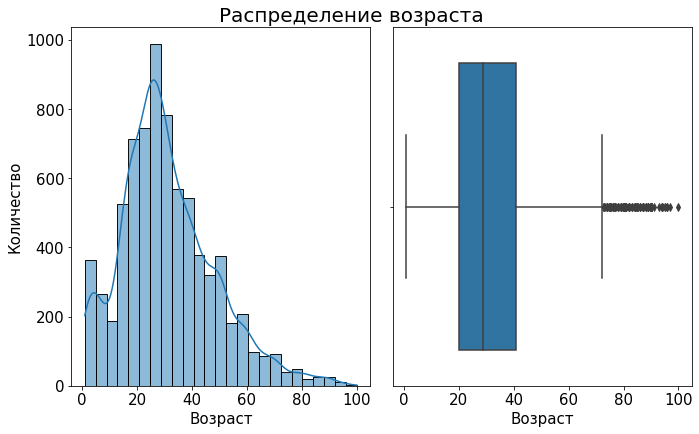

In [7]:
# Построение гистограммы и графика "ящик с усами"
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 15})

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(data_raw['real_age'], bins=auto_bins(data_raw), kde=True)
plt.xlabel("Возраст")
plt.ylabel("Количество")

# График "ящик с усами"
plt.subplot(1, 2, 2)
sns.boxplot(data_raw['real_age'])
plt.xlabel("Возраст")

plt.tight_layout()
plt.suptitle("Распределение возраста", fontsize=20, y=1.01)
plt.show()

In [8]:
# Разделение данных на тренировочный и валидационный наборы
train_data, val_data = train_test_split(data_raw, test_size=0.25, random_state=RANDOM_STATE)

In [9]:
# Проверка
print('Размер обучающей выборки (file_name) -', train_data.shape[0])
print('Размер обучающей выборки (real_age) -', val_data.shape[0])

Размер обучающей выборки (file_name) - 5693
Размер обучающей выборки (real_age) - 1898


In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
validation_datagen = ImageDataGenerator(
    rescale=1./255)

In [12]:
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=RANDOM_STATE)

Found 5693 validated image filenames.


In [13]:
val_datagen_flow = validation_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=RANDOM_STATE)

Found 1898 validated image filenames.


In [14]:
train_features, train_target = next(train_datagen_flow)

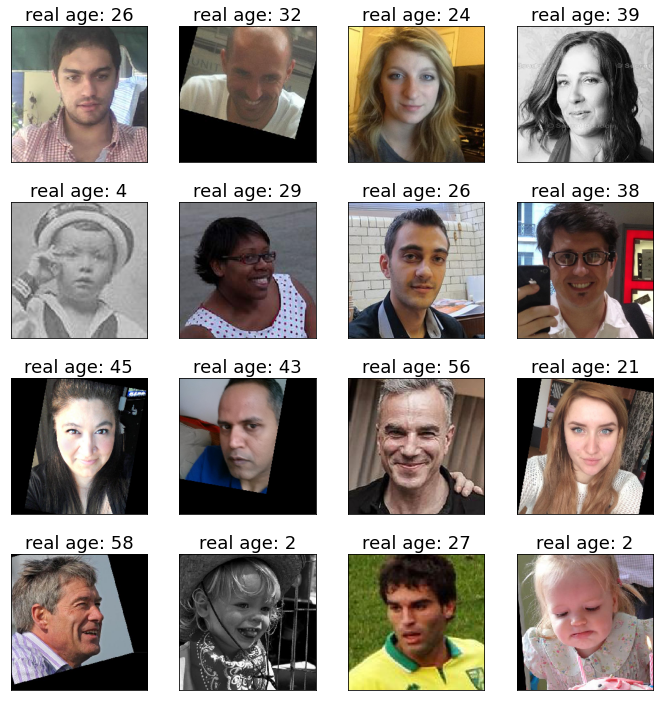

In [15]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(train_features[i])
    plt.title('real age: ' + str(train_target[i]))
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод: В ходе исследования была рассмотрен датасет, состоящий из фотографии человека и его возраста. Размер выборки - 7591.  Средний возраст людей из датасета - 31 год, медианный возраст - 29 лет. Средний возраст выше медианного, а также правый "ус" ящика, обозначающий верхний квартиль, оказывается заметно длиннее, чем левый "ус", отмечающий нижний квартиль. Это указывает на то, что хвост распределения стремится к высоким значениям и имеет большой размах. Распределение неравномерное (смещение в левую часть). Из этого можно сделать вывод, что модель будет лучше всего предсказывать возраст людей 20-41 лет так, для людей этого возраста больше всего данных. При предсказании возраста людей страше 75 лет метрики модели будут хуже. Как видно из примеров датасета, встречаются как цветные так, и черно-белые изображения. Исходя из примеров изображений можно сказать хотя часть фотографий плохого качества, но в целом датасет предстваляет собой качественную выборку фотографий для нашей задачи. Исключить можно было бы только фотографии детей (которые не могут являться клиентами магазина). Так как, все фотографии представляют собой лица людей, то при обучении модели из аугментации имеет смысл делать только вертикальное отзеркаливание.**

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def load_train(path):
    data_raw = pd.read_csv(path + '/labels.csv')
    train_data, val_data = train_test_split(data_raw, test_size=0.25, random_state=42)

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42
    )

    return train_datagen_flow

def load_test(path):
    data_raw = pd.read_csv(path + '/labels.csv')
    train_data, val_data = train_test_split(data_raw, test_size=0.25, random_state=42)

    validation_datagen = ImageDataGenerator(rescale=1./255)

    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42
    )

    return val_datagen_flow
	

def create_model(input_shape):
    optimizer = Adam(lr=0.0001) 
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False) 

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=50,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/50
178/178 - 48s - loss: 232.9107 - mae: 10.8120 - val_loss: 751.2259 - val_mae: 22.3710
Epoch 2/50
178/178 - 40s - loss: 75.5435 - mae: 6.5354 - val_loss: 779.5780 - val_mae: 22.9161
Epoch 3/50
178/178 - 39s - loss: 51.1041 - mae: 5.4230 - val_loss: 300.1397 - val_mae: 12.7949
Epoch 4/50
178/178 - 41s - loss: 34.0383 - mae: 4.4659 - val_loss: 151.9347 - val_mae: 9.1637
Epoch 5/50
178/178 - 40s - loss: 27.3509 - mae: 3.9626 - val_loss: 102.5233 - val_mae: 7.5823
Epoch 6/50
178/178 - 40s - loss: 21.5280 - mae: 3.5162 - val_loss: 103.3212 - val_mae: 7.6304
Epoch 7/50
178/178 - 40s - loss: 17.6583 - mae: 3.2108 - val_loss: 77.6971 - val_mae: 6.6426
Epoch 8/50
178/178 - 40s - loss: 13.5224 - mae: 2.7912 - val_loss: 112.4932 - val_mae: 8.2280
Epoch 9/50
178/178 - 40s - loss: 10.9825 - mae: 2.5366 - val_loss: 74.5331 - val_mae: 6.3797
Epoch 10/50
178/178 - 41s - loss: 9.9910 - mae: 2.3762 - val_loss: 74.9148 - val_mae: 6.4097
Epoch 11/50
178/178 - 53s - loss: 9.2045 - mae: 2.2891 - val_loss: 72.9121 - val_mae: 6.3883
Epoch 12/50
178/178 - 51s - loss: 7.8065 - mae: 2.1233 - val_loss: 75.3371 - val_mae: 6.5515
Epoch 13/50
178/178 - 51s - loss: 7.4209 - mae: 2.0388 - val_loss: 71.9340 - val_mae: 6.2914
Epoch 14/50
178/178 - 49s - loss: 6.9161 - mae: 2.0007 - val_loss: 74.7562 - val_mae: 6.5601
Epoch 15/50
178/178 - 48s - loss: 6.6552 - mae: 1.9667 - val_loss: 72.9187 - val_mae: 6.3449
Epoch 16/50
178/178 - 49s - loss: 6.5529 - mae: 1.9153 - val_loss: 72.7117 - val_mae: 6.3750
Epoch 17/50
178/178 - 49s - loss: 6.8959 - mae: 1.9844 - val_loss: 70.4924 - val_mae: 6.2920
Epoch 18/50
178/178 - 52s - loss: 6.8858 - mae: 1.9911 - val_loss: 69.1661 - val_mae: 6.1941
Epoch 19/50
178/178 - 53s - loss: 7.1826 - mae: 2.0090 - val_loss: 72.7692 - val_mae: 6.2994
Epoch 20/50
178/178 - 52s - loss: 7.1672 - mae: 2.0078 - val_loss: 75.0001 - val_mae: 6.5900
Epoch 21/50
178/178 - 51s - loss: 7.4286 - mae: 2.0493 - val_loss: 72.8748 - val_mae: 6.3477
Epoch 22/50
178/178 - 50s - loss: 6.9729 - mae: 1.9883 - val_loss: 68.0425 - val_mae: 6.1251
Epoch 23/50
178/178 - 49s - loss: 7.5113 - mae: 2.0619 - val_loss: 72.8628 - val_mae: 6.3315
Epoch 24/50
178/178 - 49s - loss: 7.2779 - mae: 2.0222 - val_loss: 76.4512 - val_mae: 6.4931
Epoch 25/50
178/178 - 49s - loss: 7.0844 - mae: 1.9857 - val_loss: 66.7037 - val_mae: 6.1127
Epoch 26/50
178/178 - 49s - loss: 6.2223 - mae: 1.8733 - val_loss: 68.0766 - val_mae: 6.1701
Epoch 27/50
178/178 - 51s - loss: 5.3450 - mae: 1.7493 - val_loss: 69.5528 - val_mae: 6.2459
Epoch 28/50
178/178 - 53s - loss: 5.2914 - mae: 1.7174 - val_loss: 69.3095 - val_mae: 6.2321
Epoch 29/50
178/178 - 52s - loss: 4.9193 - mae: 1.6491 - val_loss: 66.9877 - val_mae: 6.1072
Epoch 30/50
178/178 - 51s - loss: 4.7336 - mae: 1.6414 - val_loss: 66.6968 - val_mae: 6.1404
Epoch 31/50
178/178 - 51s - loss: 4.6683 - mae: 1.6433 - val_loss: 69.2676 - val_mae: 6.1748
Epoch 32/50
178/178 - 50s - loss: 4.7505 - mae: 1.6330 - val_loss: 68.4162 - val_mae: 6.1766
Epoch 33/50
178/178 - 49s - loss: 5.0403 - mae: 1.6877 - val_loss: 68.5567 - val_mae: 6.1788
Epoch 34/50
178/178 - 49s - loss: 4.9471 - mae: 1.6854 - val_loss: 65.6890 - val_mae: 6.0245
Epoch 35/50
178/178 - 49s - loss: 5.0640 - mae: 1.6936 - val_loss: 73.4164 - val_mae: 6.4033
Epoch 36/50
178/178 - 49s - loss: 4.8501 - mae: 1.6638 - val_loss: 67.6493 - val_mae: 6.1258
Epoch 37/50
178/178 - 52s - loss: 5.0235 - mae: 1.6995 - val_loss: 67.4485 - val_mae: 6.0927
Epoch 38/50
178/178 - 53s - loss: 4.8382 - mae: 1.6474 - val_loss: 71.3450 - val_mae: 6.2104
Epoch 39/50
178/178 - 53s - loss: 4.6357 - mae: 1.6160 - val_loss: 75.4239 - val_mae: 6.4170
Epoch 40/50
178/178 - 51s - loss: 4.5817 - mae: 1.6059 - val_loss: 64.8641 - val_mae: 6.0149
Epoch 41/50
178/178 - 51s - loss: 4.4995 - mae: 1.5852 - val_loss: 64.4077 - val_mae: 5.9418
Epoch 42/50
178/178 - 48s - loss: 4.0540 - mae: 1.5125 - val_loss: 64.3437 - val_mae: 5.9334
Epoch 43/50
178/178 - 48s - loss: 3.7624 - mae: 1.4703 - val_loss: 65.7496 - val_mae: 5.9952
Epoch 44/50
178/178 - 47s - loss: 3.6043 - mae: 1.4326 - val_loss: 64.2723 - val_mae: 5.9384
Epoch 45/50
178/178 - 42s - loss: 3.4166 - mae: 1.3987 - val_loss: 64.8127 - val_mae: 5.9798
Epoch 46/50
178/178 - 41s - loss: 3.4769 - mae: 1.3993 - val_loss: 67.5391 - val_mae: 6.1440
Epoch 47/50
178/178 - 43s - loss: 3.3462 - mae: 1.3735 - val_loss: 67.3439 - val_mae: 6.1532
Epoch 48/50
178/178 - 43s - loss: 3.4782 - mae: 1.4088 - val_loss: 70.3778 - val_mae: 6.2268
Epoch 49/50
178/178 - 43s - loss: 3.5793 - mae: 1.4294 - val_loss: 64.8267 - val_mae: 5.9683
Epoch 50/50
178/178 - 42s - loss: 3.6458 - mae: 1.4431 - val_loss: 64.3696 - val_mae: 5.9708

60/60 - 11s - loss: 64.3696 - mae: 5.9708
Test MAE: 5.9708

```

## Анализ обученной модели

В данной работе были изучены данные, представляющие собой фотографию человека и его возраст. Средний возраст людей из датасета - 31 год, медианный возраст - 29 лет.

Обученная модель дает хороший результат на валидационной выборке. Среднее абсолютное отклонение 5.97 лет. Число эпох можно немного снизить (до 45) так, как на последних трех эпохах видно что, модель немного переобучилась.

Так, как модель позволяет сегментировать покупателей по возрастным группам, используя полученную модель можно анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы. 

Для второй задачи - контролировать добросовестность кассиров при продаже алкоголя, модель подходит меньше так, как среднее абсолютное отклонение для этой задачи довольно большое. Это может привести к некоторым неточностям в контроле. Для выполнения этой задачи следует провести отдельное исследование с датасетом людей возрастом около 18 лет.